CS229 Final Project Baseline

Author: Matthew Ding

This file contains the code for my baseline implementation of my project. This notebook contains several experiments involving SVMs learning on numerical data generated from Markov chains. In particular, the problem I try to learn is a multi-class classification problem. Given a vector of integers, the 

For my dataset, I defined a Markov chain on four states and generated sequences of variable length by sampling from the chain. The label of each example is the most frequent number in the sequence. In particular, I designed the Markov chain so that each state has a relatively high probability of transitioning to state (1). So in particular, state (1) has a higher chance of being the most-common state, especially in longer sequences. I trained a SVM on this data and evaluated it on a separate, randomly-generated test set from the same probability distribution.

I then Huffman encoded the training and test examples (labels are unmodified). I converted the huffman binary into an array of bits (0s and 1s) and trained the SVM over this modified dataset. I think evaluated the accuracy of the model on the modified test set. I plotted the results for varying sequence lengths.

I found that SVM had lower accuracy on Huffman encoded data for all sequence lengths. However, interestingly, the accuracy of the model was higher than I expected it to be. There was a consistent 3-4% lower accuracy over encoded data. Further, this gap did not increase significantly as the size of the training sequence increased. That is, the accuracies did not change much as the labels had less variety (as the length of sequences increased, more examples had a label of "2" and few had other labels --- a result of the law of large numbers). These results are promising and suggest that ML models may achieve similar performance on data that has been Huffman encoded. For next steps, I plan to use more expressive models (i.e., Transformers) that can learn innate relationships better and possibly expand my experiments from simply problems involving Markov chains to more complicated problems in other domains (e.g., natural language).

In [1]:
import sys
import numpy as np

from collections import defaultdict
from dahuffman import HuffmanCodec
from markovchain import MarkovChain
from sklearn import svm
from matplotlib import pyplot as plt

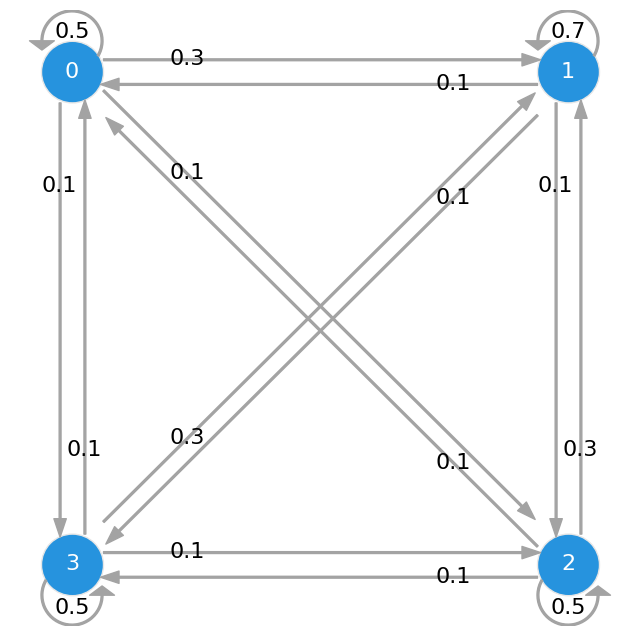

In [2]:
# markov chain with transition probabilities equal 
"""
p = np.array([
    [0.5, 0.3, 0.1, 0.1],
    [0.1, 0.7, 0.1, 0.1],
    [0.1, 0.3, 0.5, 0.1],
    [0.1, 0.3, 0.1, 0.5]
])
"""
p = np.identity(4) * 4 + np.ones((4, 4))
p[:, 1] += 2
# normalize
p /= 10


mc = MarkovChain(p, [str(i) for i in range(len(p))])
mc.draw()

In [3]:
def generate_sample(length):
    # generate an example using the Markov chain
    sample = [np.random.choice(range(4))]
    for _ in range(length):
        sample.append(np.random.choice(range(4), p=p[sample[-1]]))
    return sample[1:]

In [4]:
"""
Part 1: Basic SVM model on generated data
"""

NUM_TRAIN_SAMPLES = 9000
NUM_TEST_SAMPLES = 1000
SEQUENCE_LENGTH = 10

# task is to predict the next digit given the previous one
# generate sequences of length 10, e.g., (x1, x2, ... x10)
# label is the most frequent digit
train_x, train_y = [], []
for i in range(NUM_TRAIN_SAMPLES):
    sample = generate_sample(SEQUENCE_LENGTH) 
    train_x.append(sample)
    train_y.append(np.bincount(sample).argmax())

test_x, test_y = [], []
for i in range(NUM_TEST_SAMPLES):
    sample = generate_sample(SEQUENCE_LENGTH)
    test_x.append(sample)
    test_y.append(np.bincount(sample).argmax())


In [5]:
clf = svm.SVC()
clf.fit(train_x, train_y)

SVC()

In [6]:
print("SVM Accuracy on Uncompressed Data: ", np.sum(clf.predict(test_x) == test_y) / NUM_TEST_SAMPLES)

SVM Accuracy on Uncompressed Data:  0.883


In [7]:
"""
Part 2: Training SVM model on compressed data
"""
freq = defaultdict(int)
for example in train_x:
    for i in example:
        freq[i] += 1
codec = HuffmanCodec.from_data(freq)

In [8]:
def compress_to_bit_arr(x):
    #compresses a string with our Codec and returns a bit array
    return [int(digit) for digit in bin(int.from_bytes(x, byteorder=sys.byteorder))[2:]]

def bitstring_to_bytes(s):
    # citation: https://stackoverflow.com/questions/32675679/convert-binary-string-to-bytearray-in-python-3
    s = "".join([str(bit) for bit in s])
    v = int(s, 2)
    b = bytearray()
    while v:
        b.append(v & 0xff)
        v >>= 8
    return bytes(b)

# sanity check
for x in train_x[:10]:
    x = codec.encode(x)
    assert(x == bitstring_to_bytes(compress_to_bit_arr(x)))

In [9]:
compressed_train_x = [compress_to_bit_arr(codec.encode(example)) for example in train_x]
max_length = max([len(x) for x in compressed_train_x])
print(f"compressed data length: {max_length} bits")
# padding to prevent jagged arrays
for elem in compressed_train_x:
    while(len(elem) < max_length):
        elem.append(-1)

compressed_test_x = [compress_to_bit_arr(codec.encode(example)) for example in test_x]
# padding to prevent jagged arrays
for elem in compressed_test_x:
    while(len(elem) < max_length):
        elem.append(-1)


compressed_clf = svm.SVC()
compressed_clf.fit(compressed_train_x, train_y)

compressed data length: 40 bits


SVC()

In [10]:
print("SVM Accuracy on Uncompressed Data: ", np.sum(compressed_clf.predict(compressed_test_x) == test_y) / NUM_TEST_SAMPLES)

SVM Accuracy on Uncompressed Data:  0.862


In [11]:
"""
Part 3: Comparing results for various sequence lengths
"""
uncompressed_acc, compressed_acc = [], []

lengths = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

for seq_length in lengths:
    train_x, train_y = [], []
    for i in range(NUM_TRAIN_SAMPLES):
        sample = generate_sample(SEQUENCE_LENGTH) 
        train_x.append(sample)
        train_y.append(np.bincount(sample).argmax())

    test_x, test_y = [], []
    for i in range(NUM_TEST_SAMPLES):
        sample = generate_sample(SEQUENCE_LENGTH)
        test_x.append(sample)
        test_y.append(np.bincount(sample).argmax())
    clf = svm.SVC()
    clf.fit(train_x, train_y)
    
    uncompressed_acc.append(np.sum(clf.predict(test_x) == test_y) / NUM_TEST_SAMPLES)

    freq = defaultdict(int)
    for example in train_x:
        for i in example:
            freq[i] += 1
    codec = HuffmanCodec.from_data(freq)

    compressed_train_x = [compress_to_bit_arr(codec.encode(example)) for example in train_x]
    max_length = max([len(x) for x in compressed_train_x])
    # padding to prevent jagged arrays
    for elem in compressed_train_x:
        while(len(elem) < max_length):
            elem.append(-1)

    compressed_test_x = [compress_to_bit_arr(codec.encode(example)) for example in test_x]
    # padding to prevent jagged arrays
    for elem in compressed_test_x:
        while(len(elem) < max_length):
            elem.append(-1)

    compressed_clf = svm.SVC()
    compressed_clf.fit(compressed_train_x, train_y)

    compressed_acc.append(np.sum(compressed_clf.predict(compressed_test_x) == test_y) / NUM_TEST_SAMPLES)

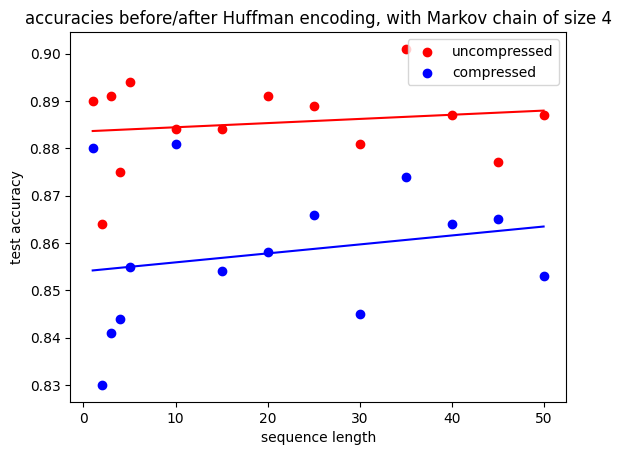

In [12]:
plt.scatter(lengths, uncompressed_acc, label="uncompressed", color="r")
plt.scatter(lengths, compressed_acc, label="compressed", color="b")
# citation: https://stackoverflow.com/questions/22239691/code-for-best-fit-straight-line-of-a-scatter-plot-in-python
plt.plot(lengths, np.poly1d(np.polyfit(lengths, uncompressed_acc, 1))(lengths), color="r")
plt.plot(lengths, np.poly1d(np.polyfit(lengths, compressed_acc, 1))(lengths), color="b")
plt.title("accuracies before/after Huffman encoding, with Markov chain of size 4")
plt.xlabel("sequence length")
plt.ylabel("test accuracy")
plt.legend()
plt.show()